In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import awkward as ak
import mplhep as hep
import vector
hep.style.use("CMS")

In [2]:
data_directory = "/global/homes/r/rmilton/m3246/rmilton/H1Unfold/jet_data/"
file_name = "kt_rapgap_jets_nogenmask_alljets_bothsteps.root"
with ur.open("{file}:jets".format(file=data_directory+file_name)) as out:
    jets = out.arrays(["eta", "px", "py", "pz", "E", "pT", "phi"])
    print("Number of events:",out.num_entries)
with ur.open("{file}:event".format(file=data_directory+file_name)) as event:
    event_info = event.arrays(["Q2", "y", "elec_pT","elec_eta","elec_phi", "weight", "step2_weights"])
    print("Number of events:",event.num_entries)

Number of events: 587265
Number of events: 587265


In [3]:
data_directory = "/global/homes/r/rmilton/m3246/rmilton/H1Unfold/jet_data/"
file_name = "kt_H1_jets_alljets_noelectron.root"
with ur.open("{file}:jets".format(file=data_directory+file_name)) as out:
    data_jets = out.arrays(["eta", "px", "py", "pz", "E", "pT", "phi"])
    print("Number of events:",out.num_entries)
with ur.open("{file}:event".format(file=data_directory+file_name)) as event:
    data_event_info = event.arrays(["Q2", "y", "elec_pT","elec_eta","elec_phi", "weight"])
    print("Number of events:",event.num_entries)

Number of events: 213702
Number of events: 213702


In [4]:
event_mask = (event_info["y"] > .2) & (event_info["y"] < 0.7) & (event_info["Q2"] > 150)
filtered_events = event_info[event_mask]
event_weights = filtered_events["weight"]
step2_weights = filtered_events["step2_weights"]
print(len(event_weights), len(step2_weights))
filtered_jets = jets[event_mask]

jet_mask = (filtered_jets["pT"] > 10)
broadcasted_weights = []

num_jets_per_event = len(jet_mask[0])
event_weights = np.concatenate([np.repeat(event_weight, num_jets_per_event) for event_weight in event_weights])
event_weights = np.array(event_weights)[ak.flatten(jet_mask)]

step2_weights = np.concatenate([np.repeat(unfolded_weight, num_jets_per_event) for unfolded_weight in step2_weights])
step2_weights = np.array(step2_weights)[ak.flatten(jet_mask)]

event_Q2 = np.concatenate([np.repeat(Q2, num_jets_per_event) for Q2 in filtered_events["Q2"]])
event_Q2 = np.array(event_Q2)[ak.flatten(jet_mask)]

event_elec_pT = np.concatenate([np.repeat(elec_pT, num_jets_per_event) for elec_pT in filtered_events["elec_pT"]])
event_elec_pT = np.array(event_elec_pT)[ak.flatten(jet_mask)]

event_elec_phi = np.concatenate([np.repeat(elec_phi, num_jets_per_event) for elec_phi in filtered_events["elec_phi"]])
event_elec_phi = np.array(event_elec_phi)[ak.flatten(jet_mask)]

selected_jets = filtered_jets[jet_mask]
flattened_eta = selected_jets["eta"]
flattened_px = selected_jets["px"]
flattened_py = selected_jets["py"]
flattened_pz = selected_jets["pz"]
flattened_pT = selected_jets["pT"]
flattened_E = selected_jets["E"]
flattened_phi = selected_jets["phi"]

587265 587265


In [5]:
paper_pT = [12.3390, 18.1112, 26.5836, 39.01933, 57.27255, 84.064603]
paper_pT_cross_section = [.1147, .0439, .0112, .00245, .00048, .000064]
paper_pT_rapgap = [.117, .043, .0105, .0023, .00052, .000076]

paper_eta = [-.650, .050, .750, 1.4500, 2.1500]
paper_eta_cross_section = [.337, .605, .331, .1096, .0444]
paper_eta_rapgap = [.292, .629, .354, .113, .042]

paper_qTQ = [.03, .102, .21, .389, .716, 1.2988, 2.3359]
paper_qTQ_cross_section = [3.51, 3.207, 1.65, .691, .223, .0705, .0059]
paper_qTQ_rapgap = [4.26, 3.1, 1.46, .603, .192, .0558, .00456]

paper_deltaphi = [.03, .077, .14, .26, .440, .741, 1.2343]
paper_deltaphi_cross_section = [5.93, 3.622, 2.03, 1.02, .431, .161, .0640]
paper_deltaphi_rapgap = [6.51, 3.24, 1.71, .814, .37, .137, .052]

paper_Q2 = [150, 200, 280, 400, 700, 1100, 1700, 3500, 8000]

In [6]:
def get_binning(centers):
    edges = []
    for i, center in enumerate(centers):
        if i == 0:
            first_bin_spacing = centers[i+1] - center
            edges.append(center - first_bin_spacing/2)
            edges.append(center + first_bin_spacing/2)
        else:
            bin_edge =  2 * (center - edges[-1]/2)
            edges.append(bin_edge)
    return np.array(edges)

In [7]:
pT_binning = get_binning(paper_pT)
eta_binning = get_binning(paper_eta)
qTQ_binning = get_binning(paper_qTQ)
deltaphi_binning = get_binning(paper_deltaphi)
Q2_binning = get_binning(paper_Q2)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

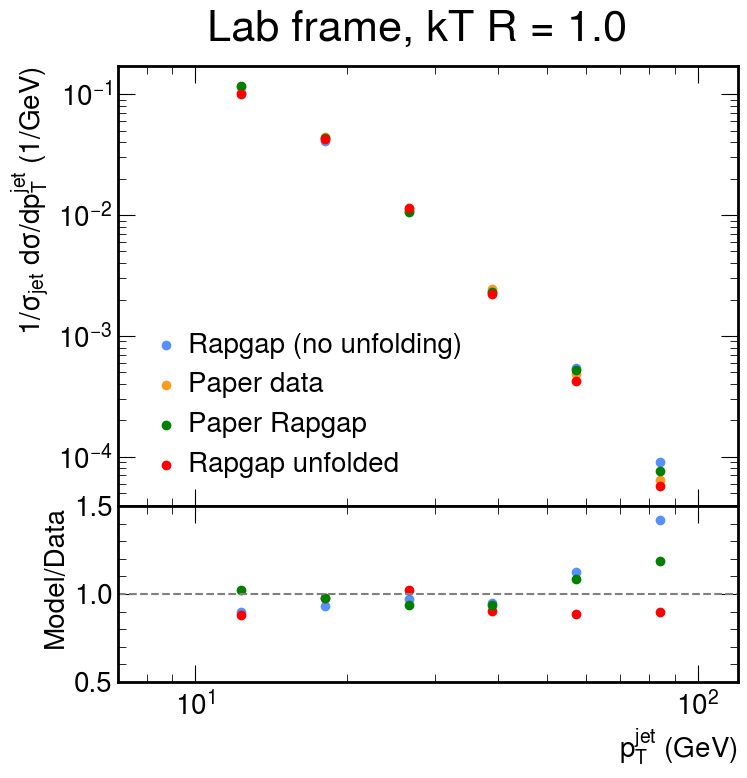

In [8]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)

xlow, xhigh = 7, 120
n,bins = np.histogram(flattened_pT, weights = event_weights, density=True, bins = pT_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_pT, paper_pT_cross_section, label="Paper data")
axs[0].scatter(paper_pT, paper_pT_rapgap, label="Paper Rapgap", color='green')
n_unfolded,bins_unfolded = np.histogram(flattened_pT, weights = event_weights*step2_weights, density=True, bins = pT_binning)
axs[0].scatter(bins_unfolded[:-1]+ 0.5*(bins_unfolded[1:] - bins_unfolded[:-1]), n_unfolded, label="Rapgap unfolded", color='red')


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/dp_T^{jet}~(1/GeV)$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)


axs[1].scatter(paper_pT, n/paper_pT_cross_section)
axs[1].scatter(paper_pT, n_unfolded/paper_pT_cross_section, color='red')
axs[1].scatter(paper_pT, np.asarray(paper_pT_rapgap)/paper_pT_cross_section, color = 'green')
axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.5, 1.5)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed' )
plt.xlabel("$p^{jet}_T$ (GeV)", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

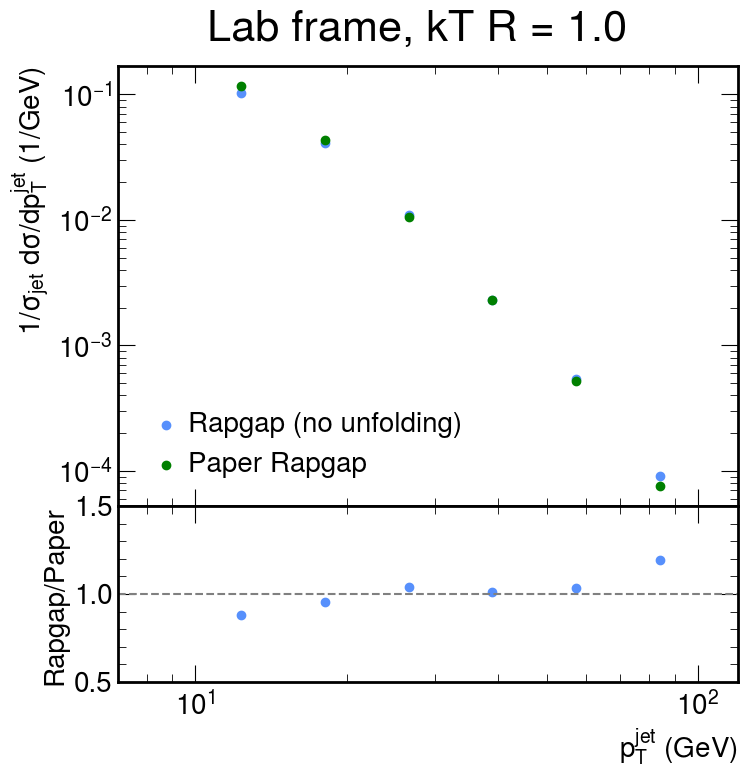

In [9]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)

xlow, xhigh = 7, 120
n,bins = np.histogram(flattened_pT, weights = event_weights, density=True, bins = pT_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_pT, paper_pT_rapgap, label="Paper Rapgap", color='green')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/dp_T^{jet}~(1/GeV)$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)


axs[1].scatter(paper_pT, n/paper_pT_rapgap)
axs[1].set_ylabel("Rapgap/Paper", fontsize=20)
axs[1].set_ylim(0.5, 1.5)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed' )
plt.xlabel("$p^{jet}_T$ (GeV)", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

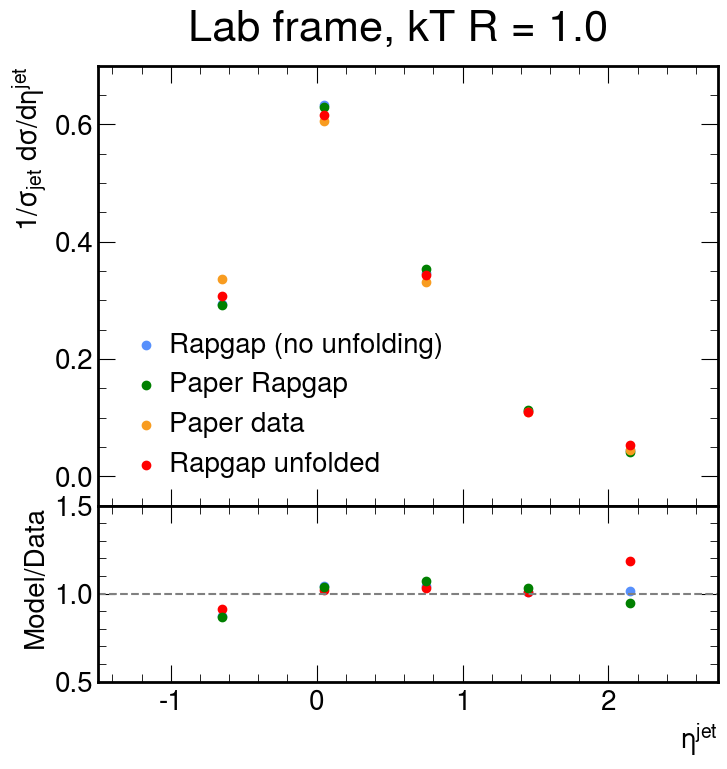

In [10]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)

xlow, xhigh = -1.5, 2.75
n,bins = np.histogram(flattened_eta, weights =event_weights, density=True, bins = eta_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_eta, paper_eta_rapgap, label="Paper Rapgap", color='green')

axs[0].scatter(paper_eta, paper_eta_cross_section, label="Paper data")

n_unfolded,bins_unfolded = np.histogram(flattened_eta, weights = event_weights*step2_weights, density=True, bins = eta_binning)
axs[0].scatter(bins_unfolded[:-1]+ 0.5*(bins_unfolded[1:] - bins_unfolded[:-1]), n_unfolded, label="Rapgap unfolded", color='red')

axs[0].set_xlim(-1.5,2.75)
axs[0].set_ylim(-.05,.7)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/d\eta^{jet}$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].scatter(paper_eta, n/paper_eta_cross_section)
axs[1].scatter(paper_eta, n_unfolded/paper_eta_cross_section, color='red')
axs[1].scatter(paper_eta, np.asarray(paper_eta_rapgap)/paper_eta_cross_section, color = 'green')

axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.5, 1.5)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')
plt.xlabel("$\eta^{jet}$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

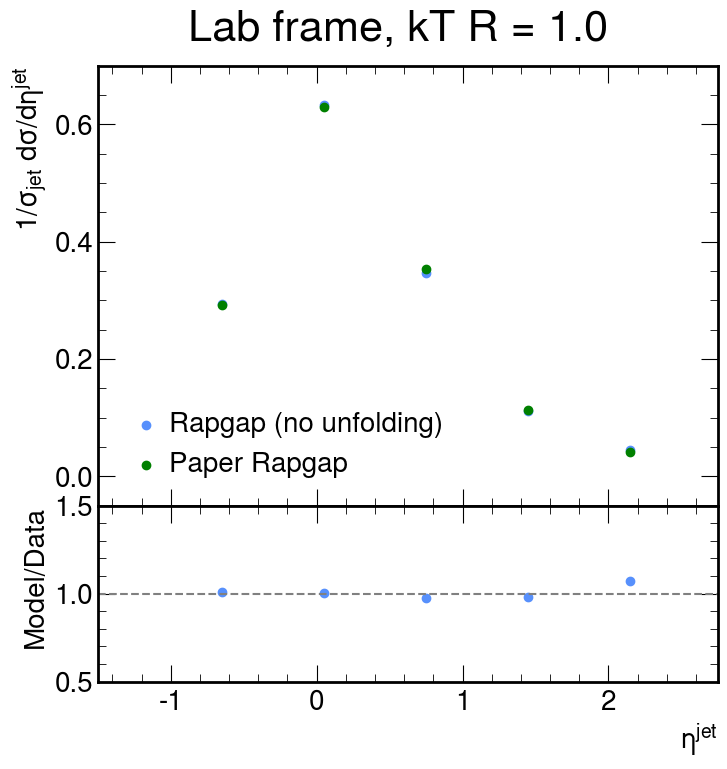

In [11]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)

xlow, xhigh = -1.5, 2.75
n,bins = np.histogram(flattened_eta, weights =event_weights, density=True, bins = eta_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_eta, paper_eta_rapgap, label="Paper Rapgap", color='green')

axs[0].set_xlim(-1.5,2.75)
axs[0].set_ylim(-.05,.7)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/d\eta^{jet}$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].scatter(paper_eta, n/paper_eta_rapgap)
axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.5, 1.5)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')
plt.xlabel("$\eta^{jet}$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

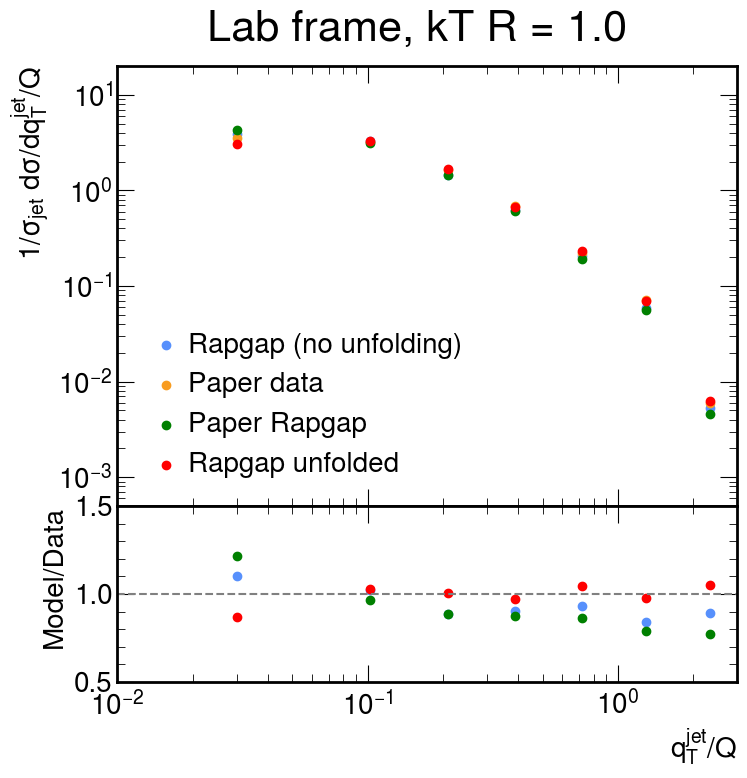

In [12]:
qTjet = np.sqrt((flattened_px + event_elec_pT*np.cos(event_elec_phi))**2 + (flattened_py + event_elec_pT*np.sin(event_elec_phi))**2)
qTQjet = qTjet/np.sqrt(event_Q2)

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)
xlow, xhigh = .01, 3

n,bins = np.histogram(qTQjet, weights = event_weights, density=True, bins = qTQ_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_qTQ, paper_qTQ_cross_section, label="Paper data")
axs[0].scatter(paper_qTQ, paper_qTQ_rapgap, label="Paper Rapgap", color='green')

n_unfolded,bins_unfolded = np.histogram(qTQjet, weights = event_weights*step2_weights, density=True, bins = qTQ_binning)
axs[0].scatter(bins_unfolded[:-1]+ 0.5*(bins_unfolded[1:] - bins_unfolded[:-1]), n_unfolded, label="Rapgap unfolded", color='red')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(5e-4,20)
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/dq_T^{jet}/Q$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].set_xscale('log')
axs[1].scatter(paper_qTQ, n/paper_qTQ_cross_section)
axs[1].scatter(paper_qTQ, n_unfolded/paper_qTQ_cross_section, color='red')
axs[1].scatter(paper_qTQ, np.asarray(paper_qTQ_rapgap)/paper_qTQ_cross_section, color = 'green')

axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.5, 1.5)
axs[1].set_xlim(xlow, xhigh)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')

plt.xlabel("$q_T^{jet}/Q$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

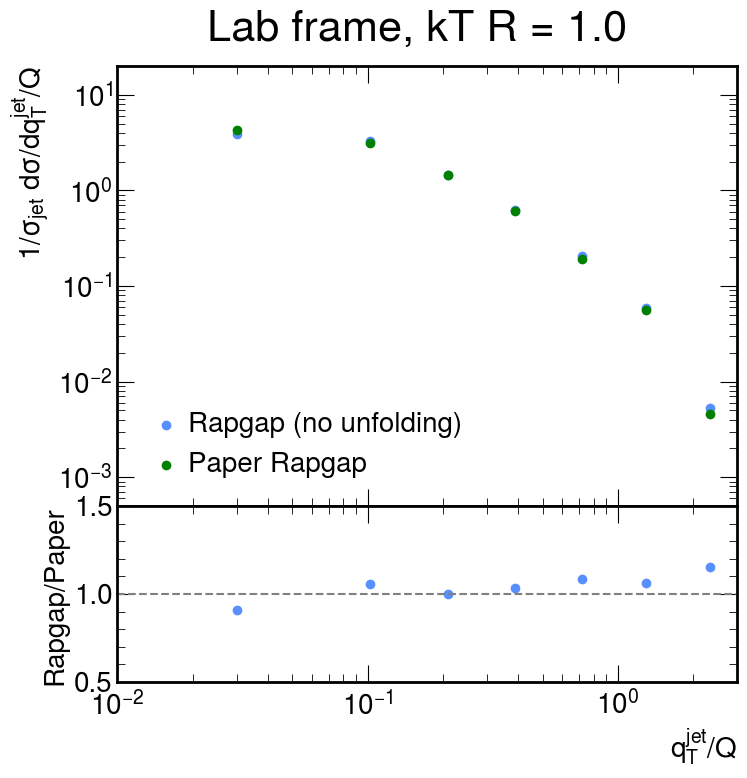

In [13]:
qTjet = np.sqrt((flattened_px + event_elec_pT*np.cos(event_elec_phi))**2 + (flattened_py + event_elec_pT*np.sin(event_elec_phi))**2)
qTQjet = qTjet/np.sqrt(event_Q2)

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)
xlow, xhigh = .01, 3

n,bins = np.histogram(qTQjet, weights = event_weights, density=True, bins = qTQ_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_qTQ, paper_qTQ_rapgap, label="Paper Rapgap", color='green')


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(5e-4,20)
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/dq_T^{jet}/Q$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].set_xscale('log')
axs[1].scatter(paper_qTQ, n/paper_qTQ_rapgap)

axs[1].set_ylabel("Rapgap/Paper", fontsize=20)
axs[1].set_ylim(0.5, 1.5)
axs[1].set_xlim(xlow, xhigh)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')

plt.xlabel("$q_T^{jet}/Q$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

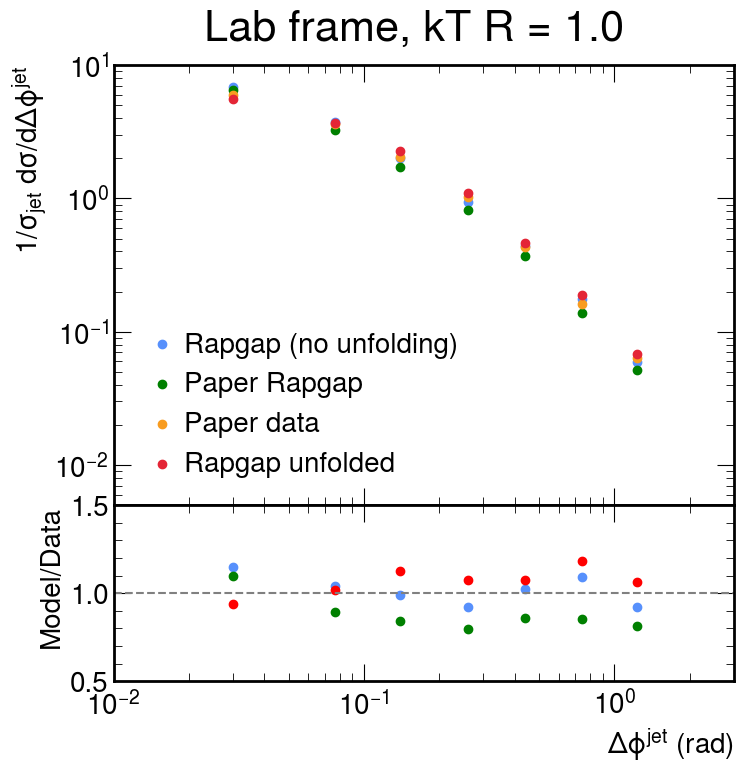

In [14]:
delta_phi = np.absolute(np.pi + flattened_phi - event_elec_phi)
delta_phi = np.where(delta_phi > 2 * np.pi, delta_phi - 2 * np.pi, delta_phi)

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)
xlow, xhigh = .01, 3

n,bins = np.histogram(delta_phi, weights = event_weights, density=True, bins = deltaphi_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_deltaphi, paper_deltaphi_rapgap, label="Paper Rapgap", color='green')

axs[0].scatter(paper_deltaphi, paper_deltaphi_cross_section, label="Paper data")

n_unfolded,bins_unfolded = np.histogram(delta_phi, weights = event_weights*step2_weights, density=True, bins = deltaphi_binning)
axs[0].scatter(bins_unfolded[:-1]+ 0.5*(bins_unfolded[1:] - bins_unfolded[:-1]), n_unfolded, label="Rapgap unfolded")

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(5e-3,10)
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/d\Delta \phi^{jet}$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].set_xscale('log')
axs[1].scatter(paper_deltaphi, n/paper_deltaphi_cross_section)
axs[1].scatter(paper_deltaphi, n_unfolded/paper_deltaphi_cross_section, color='red')
axs[1].scatter(paper_deltaphi, np.asarray(paper_deltaphi_rapgap)/paper_deltaphi_cross_section, color='green')
axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.5, 1.5)
axs[1].set_xlim(xlow, xhigh)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')

plt.xlabel("$\Delta \phi^{jet} ~(rad)$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

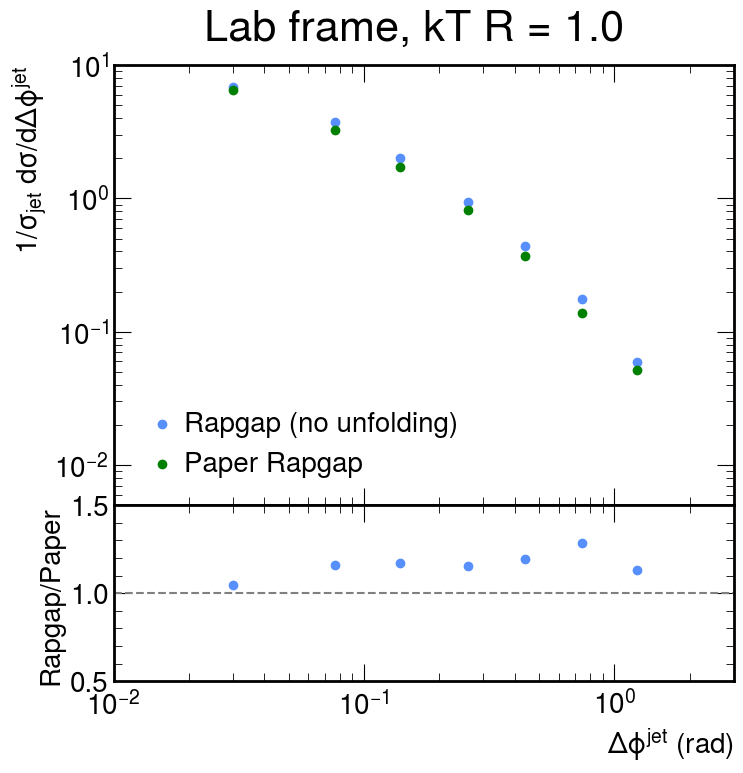

In [15]:
delta_phi = np.absolute(np.pi + flattened_phi - event_elec_phi)
delta_phi = np.where(delta_phi > 2 * np.pi, delta_phi - 2 * np.pi, delta_phi)

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)
xlow, xhigh = .01, 3

n,bins = np.histogram(delta_phi, weights = event_weights, density=True, bins = deltaphi_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_deltaphi, paper_deltaphi_rapgap, label="Paper Rapgap", color='green')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(5e-3,10)
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/d\Delta \phi^{jet}$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].set_xscale('log')
axs[1].scatter(paper_deltaphi, n/paper_deltaphi_rapgap)
axs[1].set_ylabel("Rapgap/Paper", fontsize=20)
axs[1].set_ylim(0.5, 1.5)
axs[1].set_xlim(xlow, xhigh)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')

plt.xlabel("$\Delta \phi^{jet} ~(rad)$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

[2.25853101e+03 1.72214297e+04 2.69091250e+04 1.31202422e+04
 1.33414062e+04 2.52699219e+03 2.55978906e+03 8.98500000e+02
 4.67968750e+00]
[184800.296875 732504.8125   898909.5      469510.625    474419.
  91583.25      87936.75      39831.         6264.5     ]
[5741207. 8708022. 9456115. 5074540. 5110068. 1098652. 1116452.  537168.
  152076.]
[42345900. 56943780. 63211136. 31045440. 36100544.  8157312.  7339712.
  5512960.  1695936.]


Text(1, 0, '$Q^2~(GeV^2)$')

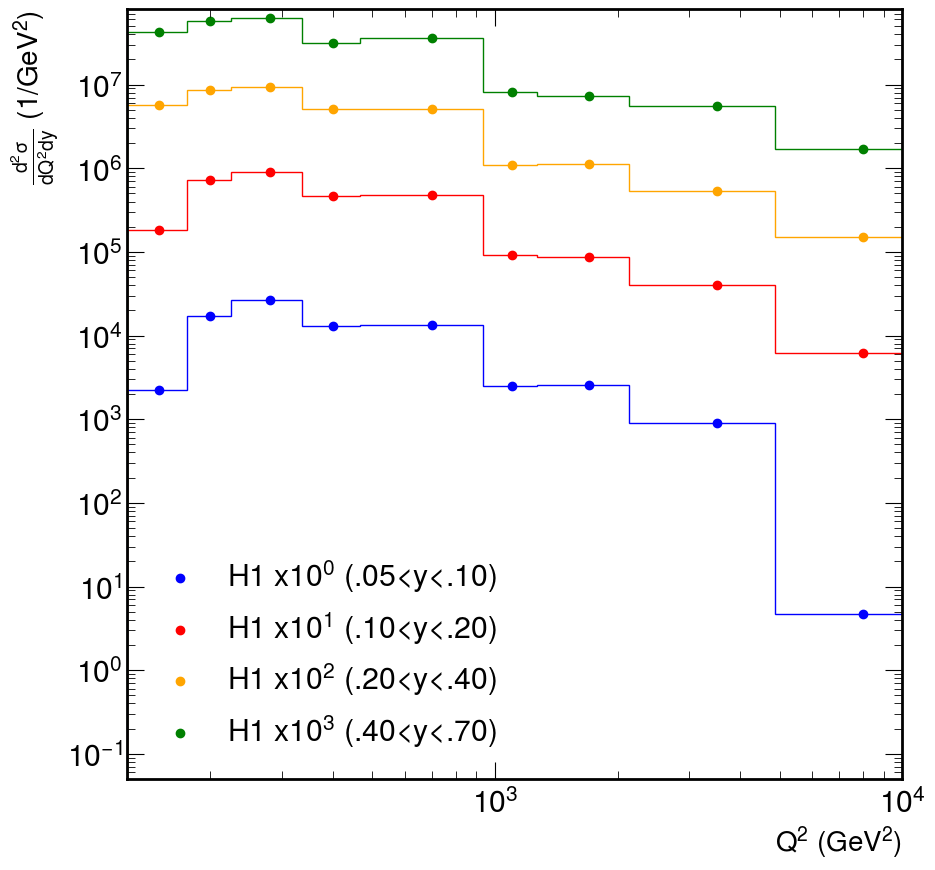

In [16]:
fig = plt.figure(figsize=(10,10))
inclusive_mask =(event_info["Q2"] > 150)
data_inclusive_mask =(data_event_info["Q2"] > 150)
luminosity = 1
y_masks = [(event_info["y"][inclusive_mask]>.05) & (event_info["y"][inclusive_mask]<.1),
           (event_info["y"][inclusive_mask]>.1) & (event_info["y"][inclusive_mask]<.2),
           (event_info["y"][inclusive_mask]>.2) & (event_info["y"][inclusive_mask]<.4),
           (event_info["y"][inclusive_mask]>.4) & (event_info["y"][inclusive_mask]<.7),
           (event_info["y"][inclusive_mask]>.7) & (event_info["y"][inclusive_mask]<.94)]

data_y_masks = [(data_event_info["y"][data_inclusive_mask]>.05) & (data_event_info["y"][data_inclusive_mask]<.1),
                (data_event_info["y"][data_inclusive_mask]>.1) & (data_event_info["y"][data_inclusive_mask]<.2),
                (data_event_info["y"][data_inclusive_mask]>.2) & (data_event_info["y"][data_inclusive_mask]<.4),
                (data_event_info["y"][data_inclusive_mask]>.4) & (data_event_info["y"][data_inclusive_mask]<.7),
                (data_event_info["y"][data_inclusive_mask]>.7) & (data_event_info["y"][data_inclusive_mask]<.94)]

multiplication_factors = [1, 10, 100, 1000, 1000]
legend_names = ["Rapgap (no unfolding) $x 10^0$ (.05<y<.10)",
                "Rapgap (no unfolding) $x 10^1$ (.10<y<.20)",
                "Rapgap (no unfolding) $x 10^2$ (.20<y<.40)",
                "Rapgap (no unfolding) $x 10^3$ (.40<y<.70)",
                "Rapgap (no unfolding) $x 10^3$ (.70<y<.94)"]

legend_names_H1 = ["H1 $x 10^0$ (.05<y<.10)",
                   "H1 $x 10^1$ (.10<y<.20)",
                   "H1 $x 10^2$ (.20<y<.40)",
                   "H1 $x 10^3$ (.40<y<.70)",
                   "H1 $x 10^3$ (.70<y<.94)"]
colors = ['blue', 'red', 'orange', 'green', 'purple']


for i, mask in enumerate(data_y_masks):
    n,bins, _ = plt.hist(data_event_info["Q2"][data_inclusive_mask][mask], weights = data_event_info["weight"][data_inclusive_mask][mask]*multiplication_factors[i]/luminosity,bins = Q2_binning, histtype='step', color=colors[i])
    if np.any(n):
        print(n)
        plt.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label=legend_names_H1[i], color=colors[i])


# for i, mask in enumerate(y_masks):
#     n,bins = np.histogram(event_info["Q2"][inclusive_mask][mask], weights = event_info["weight"][inclusive_mask][mask]*multiplication_factors[i], bins = Q2_binning)
#     if np.any(n):
#         print(n)
#         plt.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label=legend_names[i], color=colors[i], marker='s')
# axs[0].scatter(paper_pT, paper_pT_cross_section, label="Paper data")

# n_unfolded,bins_unfolded = np.histogram(jets["pT"][jet_mask], weights = event_info["weight"][jet_mask]*event_info["step2_weights"][jet_mask],bins = Q2_binning)
# axs[0].scatter(bins_unfolded[:-1]+ 0.5*(bins_unfolded[1:] - bins_unfolded[:-1]), n_unfolded, label="Rapgap unfolded", color='red')

plt.xscale('log')
plt.yscale('log')
plt.ylim(.05, 8*10**7)
plt.xlim(125, 10000)
# axs[0].set_xlim(xlow, xhigh)
plt.ylabel("$\\frac{d^2\sigma}{dQ^2dy}~(1/GeV^2)$", fontsize=20)
# plt.plot(np.NaN, np.NaN, '-', color='none', label='L = 136 $pb^{-1}$')
plt.legend()
# axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
# axs[0].tick_params(axis='both', which='major', labelsize=20)
# axs[0].tick_params(axis='both', which='minor', labelsize=20)


plt.xlabel("$Q^2~(GeV^2)$", fontsize=20)

# plt.suptitle("Lab frame, kT R = 1.0", y=0.95)